In [28]:
import numpy as np
import pandas as pd
import os
from pypinyin import pinyin, lazy_pinyin, Style
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression

#import janitor
import econtools.metrics as mt


### NSFC data

In [29]:
qn_all = pd.read_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/qn_senti.csv")

qn_all = qn_all[['申请人','申请部门','年份','立项','Senti']]
qn_all.rename(columns={'年份':'year','Senti':'senti'},inplace=True)

qn_all.head(1)

,申请人,申请部门,year,立项,senti
0,王效强,威海校区,2014,0,0.025292


In [30]:
#qn_all['立项年份'] = qn_all['year']*qn_all['立项']
#qn_all = pd.DataFrame(qn_all.groupby(['申请人']).立项年份.max()).reset_index()
qn_all.shape

(1783, 5)

In [31]:
qn_all['year'].value_counts()

year
2020    439
2019    344
2018    211
2014    208
2017    204
2016    201
2015    176
Name: count, dtype: int64

In [32]:
def pinyin(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1]+i[2])]
    elif len(i) == 2:
        capitalized = [str.capitalize(i[0]),str.capitalize(i[1])]
    else:
        print(i)
        capitalized = i
    return capitalized

def surname(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = str.capitalize(i[0])
    elif len(i) == 2:
        capitalized = str.capitalize(i[0])
    else:
        print(i)
        capitalized = i[0]
    return capitalized

def givenname(name):
    i = lazy_pinyin(name)
    if len(i) == 3:
        capitalized = str.capitalize(i[1]+i[2])
    elif len(i) == 2:
        capitalized = str.capitalize(i[1])
    else:
        print(i)
        capitalized = i[0]
    return capitalized

In [33]:
qn_all['pinyin']= qn_all['申请人'].apply(pinyin)
qn_all['surname'] = qn_all['申请人'].apply(surname)
qn_all['givenname'] = qn_all['申请人'].apply(givenname)
qn_all['author_name'] = qn_all['surname']+' '+qn_all['givenname']
qn_all = qn_all.sort_values(['申请人','year']).reset_index()
qn_all.head(1)

['Bagrat Mailyan']
['Tsona Tchinda Narcisse']
['Shani Tiwari']
['Munish Kumar Gupta']
['Bagrat Mailyan']
['Tsona Tchinda Narcisse']
['Shani Tiwari']
['Munish Kumar Gupta']
['Bagrat Mailyan']
['Tsona Tchinda Narcisse']
['Shani Tiwari']
['Munish Kumar Gupta']


,index,申请人,申请部门,year,立项,senti,pinyin,surname,givenname,author_name
0,83,Bagrat Mailyan,威海校区,2014,1,0.935095,[Bagrat Mailyan],Bagrat Mailyan,Bagrat Mailyan,Bagrat Mailyan Bagrat Mailyan


In [34]:
#qn_nsfc = qn_all.groupby(['申请人','author_name'])['author_name','立项年份'].mean().reset_index()
qn_nsfc = qn_all
qn_nsfc['year'] = qn_nsfc['year'].astype('int64')
qn_nsfc = qn_nsfc[['author_name','申请人','申请部门','year','立项','senti']].reset_index().drop(['index'],axis=1)
qn_nsfc.head(1)

,author_name,申请人,申请部门,year,立项,senti
0,Bagrat Mailyan Bagrat Mailyan,Bagrat Mailyan,威海校区,2014,1,0.935095


In [35]:
qn_nsfc['duplicated'] = qn_nsfc.duplicated(['author_name','申请部门','year'],keep=False)
qn_nsfc['dup_index'] = qn_nsfc.groupby(['author_name','申请部门']).duplicated.transform('max')
qn_nsfc_nodups = qn_nsfc[qn_nsfc['dup_index']==False]
qn_nsfc_nodups.head()

,author_name,申请人,申请部门,year,立项,senti,duplicated,dup_index
0,Bagrat Mailyan Bagrat Mailyan,Bagrat Mailyan,威海校区,2014,1,0.935095,False,False
1,Munish Kumar Gupta Munish Kumar Gupta,Munish Kumar Gupta,机械工程学院,2020,0,0.007017,False,False
2,Shani Tiwari Shani Tiwari,Shani Tiwari,环境研究院,2019,0,0.009322,False,False
3,Tsona Tchinda Narcisse Tsona Tchinda Narcisse,Tsona Tchinda Narcisse,环境研究院,2017,1,0.891362,False,False
4,Ding Yi,丁一,威海校区,2017,0,0.008722,False,False


In [36]:
qn_nsfc_nodups.shape

(1743, 8)

In [37]:
#qn_nsfc_nodups.pivot(index='author_name', columns='year', values=['立项','senti'])
# f = lambda x: x.set_index('year').reindex(range(2003, 2022))
# qn_nsfc_filled = qn_nsfc_nodups.groupby('author_name').apply(f).drop(columns='author_name').reset_index().fillna({'立项':0}, downcast='int')
# qn_nsfc_filled =qn_nsfc_filled[['author_name','year','立项','senti']]
# qn_nsfc_filled.head(10)

### Publication data

- Consolidate all publications with unique author eid
- Consolidate all author_eids
- Merge the two using author_eid 
- Reshape to wide format

### 读取论文数据

In [38]:
root_dir = "/Users/yansong/Nutstore Files/论文发表2013-2020/scopusPub/dta"
authors = os.listdir(root_dir)
os.chdir(root_dir)
# unique = 0
lists_pubs = []
for author_file in authors:
    if '.dta' in author_file:
        author_pubs = pd.read_stata(author_file)
        if 'school 1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school 1']]
            author_pubs.rename(columns={'school 1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)            
        elif 'school1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school1']]
            author_pubs.rename(columns={'school1':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)
            
        elif 'school1' in author_pubs.columns:
            author_pubs = author_pubs[['affilname', 'afid', 'author_eid', 'author_names',
           'citedby_count', 'coverDate', 'doi', 'eid', 'title', 'school']]
            author_pubs.rename(columns={'school':'school_1'},inplace=True)
            lists_pubs.append(author_pubs)
        else:
            print(author_file)
qn_pubs = pd.concat(lists_pubs)
qn_pubs['author_eid'] = pd.to_numeric(qn_pubs['author_eid'], errors='coerce')

In [39]:
len(qn_pubs.author_eid.unique())

4503

In [40]:
type(qn_pubs['author_eid'].iloc[0])

numpy.float64

In [41]:
qn_pubs.head(1)

,affilname,afid,author_eid,author_names,citedby_count,coverDate,doi,eid,title,school_1
0,Shandong First Medical University &amp; Shando...,60161479;60092862;60031419;60031031,5.598188e+10,"Jin, Yecheng;Gao, Xiaotong;Lu, Miaoqing;Chen, ...",0,10/10/2022,10.1093/hmg/ddac127,2-s2.0-85139803890,Loss of BAF (mSWI/SNF) chromatin-remodeling AT...,山大二院


### 读取作者数据

In [42]:
root_dir = "/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/scopus"
authors = os.listdir(root_dir)
os.chdir(root_dir)
unique_lists = []

for author_file in authors:
    if '.csv' in author_file:
        author_pubs = pd.read_csv(author_file)
        unique_lists.append(author_pubs)

author_ids = pd.concat(unique_lists)
author_ids['author_eid']= author_ids['eid'].str.split("-").str.get(2)
author_ids['author_eid'] = author_ids['author_eid'].astype('int64')
author_ids.head(1)

,Unnamed: 0,eid,orcid,surname,initials,givenname,affiliation,documents,affiliation_id,city,country,areas,author_eid
0,0,9-s2.0-57192706881,NaN,Chen,Z.,Zhuo,Shandong University,21,60031031,Jinan,China,SOCI (21); ENVI (13); ENGI (8),57192706881


In [43]:
len(author_ids.author_eid.unique())

4502

### 匹配作者和文章(merge on author_eid)

In [44]:
qn_author_pubs = qn_pubs.merge(author_ids,how='left',on='author_eid',indicator=True)


In [45]:
qn_author_pubs._merge.value_counts()

_merge
both          116987
left_only         42
right_only         0
Name: count, dtype: int64

In [46]:
qn_author_pubs['year'] = qn_author_pubs['coverDate'].str[-4:]
qn_author_pubs['author_name'] = qn_author_pubs['surname']+' ' +qn_author_pubs['givenname']

In [47]:
qn_author_pubs.head(1)

,affilname,afid,author_eid,author_names,citedby_count,coverDate,doi,eid_x,title,school_1,...,givenname,affiliation,documents,affiliation_id,city,country,areas,_merge,year,author_name
0,Shandong First Medical University &amp; Shando...,60161479;60092862;60031419;60031031,5.598188e+10,"Jin, Yecheng;Gao, Xiaotong;Lu, Miaoqing;Chen, ...",0,10/10/2022,10.1093/hmg/ddac127,2-s2.0-85139803890,Loss of BAF (mSWI/SNF) chromatin-remodeling AT...,山大二院,...,Congzhe,Shandong University,19,60031031,Jinan,China,BIOC (20); MEDI (14); NEUR (4),both,2022,Hou Congzhe


In [48]:
qn_author_pubs['citations'] = pd.to_numeric(qn_author_pubs['citedby_count'], errors='coerce')

### Transform the data to author by school 1 by year
- 1st: 生成论文数据
- 2nd: 引用数据
- 3rd: 平均每篇文章合作者数据
- 4th: 平均每年合作者数据

In [49]:
qn_author_year_pubs4 = qn_author_pubs.groupby(['author_name','school_1','year'])['author_names'].apply('/'.join).reset_index()
qn_author_year_pubs4['unique_coauthors'] = qn_author_year_pubs4.author_names.str.count(';')
qn_author_year_pubs4.head(1)

,author_name,school_1,year,author_names,unique_coauthors
0,Bai Caiquan,经济研究院,2015,"Bai, Caiquan;He, Yiqing;Zhou, Decai;Zhang, Yi;...",12


In [50]:
qn_author_pubs['coauthors'] = qn_author_pubs.author_names.str.count(';')
qn_author_year_pubs3 = qn_author_pubs.groupby(['author_name','school_1','year'])['coauthors'].mean().reset_index()
qn_author_year_pubs3.head(1)

,author_name,school_1,year,coauthors
0,Bai Caiquan,经济研究院,2015,4.0


In [51]:
#qn_author_year_pubs = qn_author_pubs.groupby(['author_name','school_1','year'])['author_eid'].count()
qn_author_year_pubs1 = qn_author_pubs.groupby(['author_name','school_1','year'])['author_eid'].count().reset_index()
qn_author_year_pubs2 = qn_author_pubs.groupby(['author_name','school_1','year'])['citations'].sum().reset_index()
qn_author_year_pubs  = qn_author_year_pubs1.merge(qn_author_year_pubs2,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
qn_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')


#### Merge the coauthors data

In [52]:
qn_author_year_pubs = qn_author_year_pubs.merge(qn_author_year_pubs3,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
qn_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')
qn_author_year_pubs.head(1)

,author_name,school_1,year,author_eid,citations,coauthors
0,Bai Caiquan,经济研究院,2015,3,3.0,4.0


#### Merge the unique coauthors data

In [53]:
qn_author_year_pubs = qn_author_year_pubs.merge(qn_author_year_pubs4,how='left',
                                                  on=['author_name','school_1','year'],indicator=True)
qn_author_year_pubs.drop(columns=['_merge'],inplace=True,errors='ignore')
qn_author_year_pubs.head(1)

,author_name,school_1,year,author_eid,citations,coauthors,author_names,unique_coauthors
0,Bai Caiquan,经济研究院,2015,3,3.0,4.0,"Bai, Caiquan;He, Yiqing;Zhou, Decai;Zhang, Yi;...",12


In [54]:
qn_author_year_pubs = qn_author_year_pubs.reset_index()

In [55]:
qn_author_year_pubs['year'] = qn_author_year_pubs.year.astype('int64')

In [56]:
qn_author_year_pubs.head(1)

,index,author_name,school_1,year,author_eid,citations,coauthors,author_names,unique_coauthors
0,0,Bai Caiquan,经济研究院,2015,3,3.0,4.0,"Bai, Caiquan;He, Yiqing;Zhou, Decai;Zhang, Yi;...",12


In [57]:
qn_author_year_pubs.shape

(16278, 9)

In [58]:
qn_author_year_pubs = qn_author_year_pubs[qn_author_year_pubs['year']>=2003]

In [59]:
qn_author_year_pubs.head(10)

,index,author_name,school_1,year,author_eid,citations,coauthors,author_names,unique_coauthors
0,0,Bai Caiquan,经济研究院,2015,3,3.0,4.000000,"Bai, Caiquan;He, Yiqing;Zhou, Decai;Zhang, Yi;...",12
1,1,Bai Caiquan,经济研究院,2017,3,6.0,2.000000,"Li, Zheng Tong;Bai, Cai Quan;Xiao, Wei Wei/Li,...",6
2,2,Bai Caiquan,经济研究院,2019,12,333.0,2.750000,"Bai, Caiquan;Gong, Yuan;Feng, Chen/Bai, Caiqua...",33
3,3,Bai Caiquan,经济研究院,2020,15,993.0,3.800000,"Kang, Yankun;Liang, Shuyuan;Bai, Caiquan;Feng,...",57
4,4,Bai Caiquan,经济研究院,2021,18,129.0,3.333333,"Feng, Chen;Shi, Beibei;Yan, Hong;Yang, Siying;...",60
5,5,Bai Caiquan,经济研究院,2022,24,105.0,2.500000,"Liu, Xianmei;Peng, Rui;Bai, Caiquan;Chi, Yuany...",60
6,6,Bai Caiquan,经济研究院,2023,12,12.0,3.000000,"Bai, Caiquan;Chen, Zhijun;Wang, Daoping/Liu, X...",36
7,7,Bai Chao,能源与动力工程学院,2009,4,52.0,1.500000,"Bai, Chao;Wang, Liqiu/Bai, Chao;Wang, Liqiu;Ch...",6
8,8,Bai Chao,能源与动力工程学院,2010,6,96.0,1.000000,"Bai, Chao;Wang, Liqiu/Bai, Chao;Wang, Liqiu/Ba...",6
9,9,Bai Chao,能源与动力工程学院,2011,2,10.0,1.000000,"Bai, Chao;Wang, Liqiu/Bai, Chao;Wang, Liqiu",2


In [60]:
df = qn_author_year_pubs
df.head(1)

,index,author_name,school_1,year,author_eid,citations,coauthors,author_names,unique_coauthors
0,0,Bai Caiquan,经济研究院,2015,3,3.0,4.0,"Bai, Caiquan;He, Yiqing;Zhou, Decai;Zhang, Yi;...",12


In [61]:
f = lambda x: x.set_index('year').reindex(range(2003, 2022))
df_filled = df.groupby(['author_name','school_1']).apply(f).drop(columns=['author_name','school_1']).reset_index().fillna({'author_eid':0}, downcast='int')
df_filled.head(10)



/var/folders/kp/gk4kvr5s0plbp5y3112cx_x00000gn/T/ipykernel_16068/4121535855.py:2: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df_filled = df.groupby(['author_name','school_1']).apply(f).drop(columns=['author_name','school_1']).reset_index().fillna({'author_eid':0}, downcast='int')


,author_name,school_1,year,index,author_eid,citations,coauthors,author_names,unique_coauthors
0,Bai Caiquan,经济研究院,2003,NaN,0,NaN,NaN,NaN,NaN
1,Bai Caiquan,经济研究院,2004,NaN,0,NaN,NaN,NaN,NaN
2,Bai Caiquan,经济研究院,2005,NaN,0,NaN,NaN,NaN,NaN
3,Bai Caiquan,经济研究院,2006,NaN,0,NaN,NaN,NaN,NaN
4,Bai Caiquan,经济研究院,2007,NaN,0,NaN,NaN,NaN,NaN
5,Bai Caiquan,经济研究院,2008,NaN,0,NaN,NaN,NaN,NaN
6,Bai Caiquan,经济研究院,2009,NaN,0,NaN,NaN,NaN,NaN
7,Bai Caiquan,经济研究院,2010,NaN,0,NaN,NaN,NaN,NaN
8,Bai Caiquan,经济研究院,2011,NaN,0,NaN,NaN,NaN,NaN
9,Bai Caiquan,经济研究院,2012,NaN,0,NaN,NaN,NaN,NaN


In [62]:
df_filled.shape

(60857, 9)

In [63]:
df_filled['lagged_1'] = df.groupby(['author_name'])['author_eid'].shift(1)


In [64]:
df_filled['rolling_sum']= df_filled.groupby('author_name')['author_eid'].\
                        transform(lambda s: s.rolling(2, min_periods=2).sum().shift(-1))

In [65]:
df_filled['rolling_sum3']= df_filled.groupby('author_name')['author_eid'].\
                        transform(lambda s: s.rolling(3, min_periods=3).sum().shift(-2))

In [66]:
df_filled['rolling_sum4']= df_filled.groupby('author_name')['author_eid'].\
                        transform(lambda s: s.rolling(4, min_periods=4).sum().shift(-3))

In [67]:
df_filled['rolling_sum5']= df_filled.groupby('author_name')['author_eid'].\
                        transform(lambda s: s.rolling(5, min_periods=5).sum().shift(-4))

In [68]:
df_filled.head(20)

,author_name,school_1,year,index,author_eid,citations,coauthors,author_names,unique_coauthors,lagged_1,rolling_sum,rolling_sum3,rolling_sum4,rolling_sum5
0,Bai Caiquan,经济研究院,2003,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,Bai Caiquan,经济研究院,2004,NaN,0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,0.0
2,Bai Caiquan,经济研究院,2005,NaN,0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,0.0
3,Bai Caiquan,经济研究院,2006,NaN,0,NaN,NaN,NaN,NaN,12.0,0.0,0.0,0.0,0.0
4,Bai Caiquan,经济研究院,2007,NaN,0,NaN,NaN,NaN,NaN,15.0,0.0,0.0,0.0,0.0
5,Bai Caiquan,经济研究院,2008,NaN,0,NaN,NaN,NaN,NaN,18.0,0.0,0.0,0.0,0.0
6,Bai Caiquan,经济研究院,2009,NaN,0,NaN,NaN,NaN,NaN,24.0,0.0,0.0,0.0,0.0
7,Bai Caiquan,经济研究院,2010,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
8,Bai Caiquan,经济研究院,2011,NaN,0,NaN,NaN,NaN,NaN,4.0,0.0,0.0,0.0,3.0
9,Bai Caiquan,经济研究院,2012,NaN,0,NaN,NaN,NaN,NaN,6.0,0.0,0.0,3.0,3.0


### 匹配自科和论文数据 （on author_eid and 申请部门 and year）

In [69]:
df_filled.head(1)

,author_name,school_1,year,index,author_eid,citations,coauthors,author_names,unique_coauthors,lagged_1,rolling_sum,rolling_sum3,rolling_sum4,rolling_sum5
0,Bai Caiquan,经济研究院,2003,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [70]:
df_filled.rename(columns={'school_1':'申请部门'},inplace=True)

In [71]:
df_filled.shape

(60857, 14)

In [72]:
qn_nsfc.shape

(1783, 8)

In [27]:
#qn_nsfc_pubs = df_filled.merge(qn_nsfc_nodups,how='left',on=['author_name','year'],indicator=True)
qn_nsfc_pubs = df_filled.merge(qn_nsfc_nodups,how='outer',on=['author_name','申请部门','year'],indicator=True)


NameError: name 'df_filled' is not defined

In [48]:
qn_nsfc_pubs._merge.value_counts()

_merge
left_only     60188
both            669
right_only        0
Name: count, dtype: int64

In [26]:
qn_nsfc_nodups.shape

(1743, 8)

In [49]:
qn_nsfc_pubs.shape

(60857, 20)

In [50]:
# qn_nsfc_pubs.sort_values(['author_name','申请部门','year'],inplace=True)

In [51]:
qn_nsfc_pubs.head(20)

,author_name,申请部门,year,index,author_eid,citations,coauthors,author_names,unique_coauthors,lagged_1,rolling_sum,rolling_sum3,rolling_sum4,rolling_sum5,申请人,立项,senti,duplicated,dup_index,_merge
0,Bai Caiquan,经济研究院,2003,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
1,Bai Caiquan,经济研究院,2004,NaN,0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
2,Bai Caiquan,经济研究院,2005,NaN,0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
3,Bai Caiquan,经济研究院,2006,NaN,0,NaN,NaN,NaN,NaN,12.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
4,Bai Caiquan,经济研究院,2007,NaN,0,NaN,NaN,NaN,NaN,15.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
5,Bai Caiquan,经济研究院,2008,NaN,0,NaN,NaN,NaN,NaN,18.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
6,Bai Caiquan,经济研究院,2009,NaN,0,NaN,NaN,NaN,NaN,24.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
7,Bai Caiquan,经济研究院,2010,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,left_only
8,Bai Caiquan,经济研究院,2011,NaN,0,NaN,NaN,NaN,NaN,4.0,0.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,left_only
9,Bai Caiquan,经济研究院,2012,NaN,0,NaN,NaN,NaN,NaN,6.0,0.0,0.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,left_only


In [52]:
qn_nsfc_pubs['立项年份'] = qn_nsfc_pubs['立项']*qn_nsfc_pubs['year']
qn_nsfc_pubs['立项年份'] = qn_nsfc_pubs.groupby(['author_name']).立项年份.transform(max)

/var/folders/kp/gk4kvr5s0plbp5y3112cx_x00000gn/T/ipykernel_75865/2180305080.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  qn_nsfc_pubs['立项年份'] = qn_nsfc_pubs.groupby(['author_name']).立项年份.transform(max)


In [53]:
qn_nsfc_pubs['立项年份'].value_counts()

立项年份
0.0       11419
2020.0     2983
2019.0     2489
2017.0     1938
2018.0     1596
2014.0     1425
2015.0     1197
2016.0     1007
Name: count, dtype: int64

In [54]:
qn_nsfc_pubs['grant_t'] = qn_nsfc_pubs['year'].astype('int64')-qn_nsfc_pubs['立项年份']
qn_nsfc_pubs.loc[qn_nsfc_pubs['立项年份']==0,'grant_t'] = 0
qn_nsfc_pubs['after_grant'] = qn_nsfc_pubs['grant_t'] >=0
qn_nsfc_pubs['after_grant'] = qn_nsfc_pubs['after_grant'].astype('int64')

<Axes: xlabel='grant_t', ylabel='rolling_sum'>

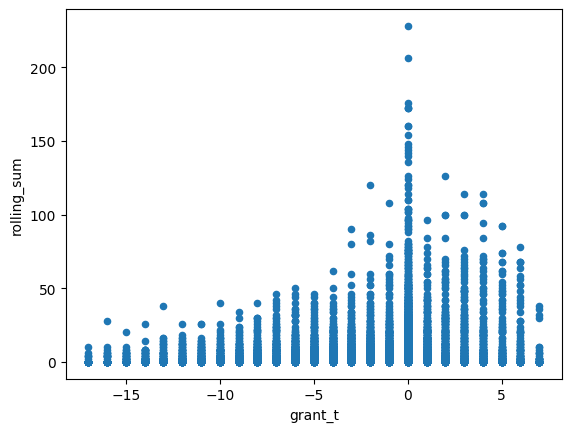

In [55]:
qn_nsfc_pubs.plot.scatter(x='grant_t',y='rolling_sum')

In [56]:
qn_nsfc_pubs.columns

Index(['author_name', '申请部门', 'year', 'index', 'author_eid', 'citations',
       'coauthors', 'author_names', 'unique_coauthors', 'lagged_1',
       'rolling_sum', 'rolling_sum3', 'rolling_sum4', 'rolling_sum5', '申请人',
       '立项', 'senti', 'duplicated', 'dup_index', '_merge', '立项年份', 'grant_t',
       'after_grant'],
      dtype='object')

In [57]:
qn_nsfc_pubs['senti_squared'] =qn_nsfc_pubs['senti']*qn_nsfc_pubs['senti']
qn_nsfc_pubs['below_cutoff'] = qn_nsfc_pubs['senti']<0.5

In [58]:
qn_nsfc_pubs['experience']  =  qn_nsfc_pubs['year'] - qn_nsfc_pubs.groupby(['author_name']).year.transform(min)

/var/folders/kp/gk4kvr5s0plbp5y3112cx_x00000gn/T/ipykernel_75865/1196035604.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  qn_nsfc_pubs['experience']  =  qn_nsfc_pubs['year'] - qn_nsfc_pubs.groupby(['author_name']).year.transform(min)


## Regressions

In [59]:
qn_nsfc_pubs.to_csv("/Users/yansong/Nutstore Files/基金研究/data/2013--2022面青/qn_reg_type2.csv")

### OLS

In [61]:
qn_nsfc_pubs.head()

,author_name,申请部门,year,index,author_eid,citations,coauthors,author_names,unique_coauthors,lagged_1,...,senti,duplicated,dup_index,_merge,立项年份,grant_t,after_grant,senti_squared,below_cutoff,experience
0,Bai Caiquan,经济研究院,2003,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left_only,NaN,NaN,0,NaN,False,0
1,Bai Caiquan,经济研究院,2004,NaN,0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,left_only,NaN,NaN,0,NaN,False,1
2,Bai Caiquan,经济研究院,2005,NaN,0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,left_only,NaN,NaN,0,NaN,False,2
3,Bai Caiquan,经济研究院,2006,NaN,0,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,left_only,NaN,NaN,0,NaN,False,3
4,Bai Caiquan,经济研究院,2007,NaN,0,NaN,NaN,NaN,NaN,15.0,...,NaN,NaN,NaN,left_only,NaN,NaN,0,NaN,False,4


In [64]:
y_var = 'rolling_sum'
X_vars = ['after_grant']
fe_var = 'author_name'
cluster_var = 'author_name'

results = mt.reg(
    qn_nsfc_pubs,                     # DataFrame
    y_var,                      # Dependent var (string)
    X_vars,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,     # Cluster var (string),
    addcons=True
)
results

KeyError: 'author_name'

In [ ]:
y_var = 'rolling_sum'
X_vars = ['after_grant','senti']
fe_var = 'author_name'
cluster_var = 'author_name'

results = mt.reg(
    qn_nsfc_pubs,                     # DataFrame
    y_var,                      # Dependent var (string)
    X_vars,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    #cluster=cluster_var,     # Cluster var (string),
    addcons=True
)
results

### IV 1st

In [ ]:
y_var = '立项'
X_vars = ['senti','senti_squared','below_cutoff']
fe_var = 'author_name'
cluster_var = 'author_name'

results = mt.reg(
    qn_nsfc_pubs,                     # DataFrame
    y_var,                      # Dependent var (string)
    X_vars,                      # Independent var(s) (string or list of strings)
    fe_name=fe_var,         # Fixed-effects/absorb var (string)
    cluster=cluster_var,     # Cluster var (string),
    addcons=True
)
results

### IV reg

In [ ]:
y = 'rolling_sum'              # Dependent var
X = ['after_grant']            # Endogenous regressor(s)
Z = ['below_cutoff']       # Instrumental variable(s)
W = ['senti','senti_squared']    # Exogenous regressor(s)
fe_var = 'author_name'


results = mt.ivreg(qn_nsfc_pubs, y, X, Z, W,    
                   fe_name=fe_var,         # Fixed-effects/absorb var (string)
                   cluster=cluster_var,     # Cluster var (string),
                   addcons=True
)
results